In [ ]:
import os
work_dir = os.path.abspath('../../..')
print(work_dir)
os.chdir(work_dir)
import sympy as sp
import numpy as np
from aiphy.experiment import default_parastructure, ExpConfig, Objstructure, DoExpType, ExpStructure, Proposition
from aiphy.experiment import concept_posx, concept_posy, concept_t, concept_dist, concept_posz
from scipy.integrate import odeint

/home/lixiang/code/ai-physicist


In [2]:
from aiphy.experiment import concept_posx, concept_posy, concept_t, concept_dist, concept_posz

In [3]:
pi = 3.1415926

exp_para = {
    "x0": default_parastructure(-1.0, 1.0),
    "y0": default_parastructure(-1.0, 1.0),
    "r0": default_parastructure(5.0, 7.0),
    "theta0": default_parastructure(0.0, 2*pi/3),
    "omega10": default_parastructure(1.0, 2.0),
    "omega20": default_parastructure(1.0, 2.0),
    "omega30": default_parastructure(1.0, 2.0),
    "v10": default_parastructure(-0.05, 0.05),
    "v20": default_parastructure(-0.05, 0.05),
    "v30": default_parastructure(-0.05, 0.05),
}

obj_info = {
    "o1": Objstructure.make_particle(1, 2),
    "o2": Objstructure.make_particle(1, 2),
    "o3": Objstructure.make_particle(1, 2),
    "clock": Objstructure.clock()
}
data_info = [
    (concept_posx, ["o1"]),
    (concept_posy, ["o1"]),
    (concept_posz, ["o1"]),
    (concept_posx, ["o2"]),
    (concept_posy, ["o2"]),
    (concept_posz, ["o2"]),
    (concept_dist, ["o1", "o2"]),
    (concept_dist, ["o2", "o1"]),
    (concept_t, ["clock"]),
]

G = 4*pi**2
acs0 = [sp.sympify("G*(m2*(x2-x1)/r12**3 + m3*(x3-x1)/r13**3)"),
        sp.sympify("G*(m1*(x1-x2)/r12**3 + m3*(x3-x2)/r23**3)"),
        sp.sympify("G*(m1*(x1-x3)/r13**3 + m2*(x2-x3)/r23**3)"),
        sp.sympify("G*(m2*(y2-y1)/r12**3 + m3*(y3-y1)/r13**3)"),
        sp.sympify("G*(m1*(y1-y2)/r12**3 + m3*(y3-y2)/r23**3)"),
        sp.sympify("G*(m1*(y1-y3)/r13**3 + m2*(y2-y3)/r23**3)"),]


In [4]:
t_end = 2.0
t_num = 100
error = 1e-8

In [13]:
exp_config = ExpConfig("celestial_2", 1, exp_para, obj_info, data_info)
exp_config.random_settings()

In [14]:
x0 = exp_config.para('x0')
y0 = exp_config.para('y0')
r0 = exp_config.para('r0')
theta0 = exp_config.para('theta0')
omega10 = exp_config.para('omega10')
omega20 = exp_config.para('omega20')
omega30 = exp_config.para('omega30')
v10 = exp_config.para('v10')
v20 = exp_config.para('v20')
v30 = exp_config.para('v30')

x10 = x0 + r0*np.cos(theta0)
x20 = x0 + r0*np.cos(theta0 + 2*pi/3)
x30 = x0 + r0*np.cos(theta0 + 4*pi/3)
y10 = y0 + r0*np.sin(theta0)
y20 = x0 + r0*np.sin(theta0 + 2*pi/3)
y30 = x0 + r0*np.sin(theta0 + 4*pi/3)
vx10 = v10*np.cos(theta0) - omega10*r0*np.sin(theta0)
vy10 = v10*np.sin(theta0) + omega10*r0*np.cos(theta0)
vx20 = v20*np.cos(theta0 + 2*pi/3) - omega20*r0*np.sin(theta0 + 2*pi/3)
vy20 = v20*np.sin(theta0 + 2*pi/3) + omega20*r0*np.cos(theta0 + 2*pi/3)
vx30 = v30*np.cos(theta0 + 4*pi/3) - omega30*r0*np.sin(theta0 + 4*pi/3)
vy30 = v30*np.sin(theta0 + 4*pi/3) + omega30*r0*np.cos(theta0 + 4*pi/3)

m1 = exp_config.get_obj_para('o1', 'm')
m2 = exp_config.get_obj_para('o2', 'm')
m3 = exp_config.get_obj_para('o3', 'm')
numeric = {'m1': m1, 'm2': m2, 'm3': m3, 'G': G}
acs = [ac.subs(numeric) for ac in acs0]

step = t_end / t_num
t = np.arange(0, t_end, step)
y0 = [x10, x20, x30, y10, y20, y30, vx10, vx20, vx30, vy10, vy20, vy30]


In [15]:
def f(y, t):
        x1, x2, x3, y1, y2, y3, vx1, vx2, vx3, vy1, vy2, vy3 = y
        r12 = np.sqrt((x1-x2)**2 + (y1-y2)**2)
        r23 = np.sqrt((x3-x2)**2 + (y3-y2)**2)
        r13 = np.sqrt((x1-x3)**2 + (y1-y3)**2)
        numeric = {'r12': r12, 'r23': r23, 'r13': r13,
                        'x1': x1, 'x2': x2, 'x3': x3, 'y1': y1, 'y2': y2, 'y3': y3,
                        'vx1': vx1, 'vx2': vx2, 'vx3': vx3, 'vy1': vy1, 'vy2': vy2, 'vy3': vy3}
        acs_n = [ac.subs(numeric) for ac in acs]
        return [vx1, vx2, vx3, vy1, vy2, vy3] + acs_n
sol = odeint(f, y0, t)
x1 = sol[:, 0]
x2 = sol[:, 1]
x3 = sol[:, 2]
y1 = sol[:, 3]
y2 = sol[:, 4]
y3 = sol[:, 5]
dist12 = np.sqrt((x1-x2)**2 + (y1-y2)**2)
dist23 = np.sqrt((x3-x2)**2 + (y3-y2)**2)
dist31 = np.sqrt((x1-x3)**2 + (y1-y3)**2)

In [24]:
x1, x2, x3, y1, y2, y3, vx1, vx2, vx3, vy1, vy2, vy3 = y0
r12 = np.sqrt((x1-x2)**2 + (y1-y2)**2)
r23 = np.sqrt((x3-x2)**2 + (y3-y2)**2)
r13 = np.sqrt((x1-x3)**2 + (y1-y3)**2)
numeric = {'r12': r12, 'r23': r23, 'r13': r13,
                'x1': x1, 'x2': x2, 'x3': x3, 'y1': y1, 'y2': y2, 'y3': y3,
                'vx1': vx1, 'vx2': vx2, 'vx3': vx3, 'vy1': vy1, 'vy2': vy2, 'vy3': vy3}
acs_n = [ac.subs(numeric) for ac in acs]

In [27]:
(x1, y1), (x2, y2), (x3, y3)

((-1.3975588902907035, 5.9184873692574325),
 (-4.515865744416982, -3.8067911221274797),
 (4.215972634949826, -2.3661728282445793))

In [29]:
(vx1, vy1), (vx2, vy2), (vx3, vy3)

((-6.799793962564867, -1.1085621906136973),
 (5.994427521763759, -7.249191423104522),
 (3.09805630011199, 8.12635859049587))

In [28]:
[(acs_n[i], acs_n[i+3]) for i in range(3)]

[(0.211516808932276, -1.34332514277968),
 (1.10812511111838, 0.559795096450155),
 (-1.21004949891045, 0.201048689742512)]

In [16]:
import matplotlib.pyplot as plt

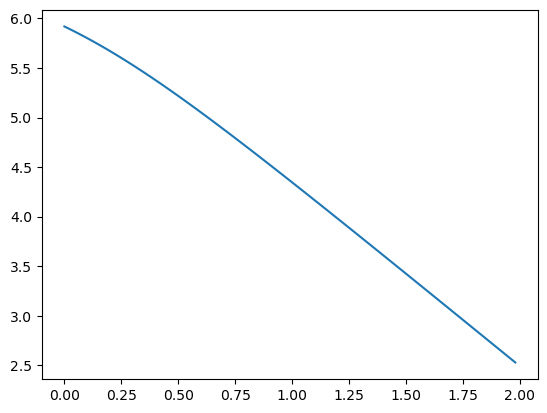

In [22]:
plt.plot(t, y1)